# <center> Example Usage of the Delayed Optimization Algorithm </center>

In [30]:
import numpy as np

## Using the Optimization Helper

### Initialization

In [31]:
from delay_optimizer import OptimizationHelper

helper = OptimizationHelper("Ackley", n=10)     # Pre-defined functions in delay_optimzier.optimization.functions

In [32]:
# Load points from array
X = np.arange(1000).reshape((100,10))  
helper.load_points(X)
print("Num points:", len(helper.x_inits))

Num points: 100


In [33]:
# Initialize random points sampled from the function domain
helper.random_points(num_points=100)
print("Num points:", len(helper.x_inits))

Num points: 100


### Optimize

In [48]:
optimization_data = helper.optimize(
    optimizer="Adam",               # Type of optmization algorithm to use
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-5,
    delay_type="stochastic",        # The delay distribution generator to use
    max_L=1,
    num_delays=5000,
    scheduler="constant",           # The type of learning rate scheduler to use
    learning_rate=1.5,
    maxiter=5000,
    output_dir="data/test_run.dat"  # (Optional) Where to save the optimization data
)

Ackley 10d (Stochastic): 100%|██████████| 5000/5000 [00:01<00:00, 2963.35it/s]


In [49]:
optimization_data.save("data/test_run.dat")     # Alternatively, you can save manually

## Manual Optimization

### Initialization

Objective Function

In [7]:
from delay_optimizer import functions

# Use a pre-defined objective function
# objective = functions.Ackley(n=2)

In [8]:
# Define a custom objective function
class Stable1d(functions.ObjectiveFunction):
    def __init__(self, c=np.pi/(2+4*np.pi**2)):
        super().__init__(1, (-3.,3.), np.array([0.]))
        self.c = c

    def get_loss_function(self):    # Need to implement this method
        def loss(x):
            return np.ravel(self.c * (x**2 - np.cos(2*np.pi*x) + 1))
        return loss

    def get_grad_function(self):    # Need to implement this method
        def grad(x):
            return 2*self.c * (x + np.pi*np.sin(2*np.pi*x))
        return grad

objective = Stable1d()

Optimizer

In [9]:
from delay_optimizer import optimizers

# Define the optimizer with a constant learning rate
optimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-5)

In [10]:
from delay_optimizer import schedulers

# Alternatively, pass a learning rate scheduler to the optimizer
# lr = schedulers.Inv(max_lr=1., gamma=.9, p=1.)
# optimizer = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-5)

In [11]:
# Can also implement a custom optimizer, though it needs to implement the initialize() and step() methods
# See the delay_optimizer.optimization.optimizers.Optimizer parent class

Delay Distribution

In [12]:
from delay_optimizer.delays import distributions

# Use a pre-defined delay distribution
# delay_type = distributions.Stochastic(max_L=1, num_delays=1000)

In [13]:
# Define a custom sequence of delay vectors
D = [np.array([0]), np.array([1]), np.array([1]), np.array([1])]
delay_type = distributions.Cyclical(D, num_delays=1000)

# This delay type will repeat your custom delay sequence as more delays are requested
# The num_delays parameter can be specified to turn off delays after a certain number of iterations

Delayed Optimizer

In [14]:
from delay_optimizer import DelayedOptimizer

delayed_optimizer = DelayedOptimizer(objective, optimizer, delay_type)

### Optimize

In [15]:
# Batch of initial states
# X = np.random.random((10,2))
X = np.random.random((10,1))

In [16]:
# To automatically perform the entire optimization run
delayed_optimizer.optimize(x_init=X, maxiter=1000)  

# The entire batch of points is optimized and final states are returned

array([ 9.51051150e-01,  9.51051150e-01,  2.67419493e-23, -6.29453168e-24,
       -1.73486207e-24,  1.94477545e-05,  9.51051150e-01,  9.51051150e-01,
        9.51051150e-01,  4.60820006e-24])

In [17]:
# To manually run delayed optimization
delayed_optimizer.initialize(X)
for i in range(1000):
    x = delayed_optimizer.step() 
x

array([[ 9.51051150e-01],
       [ 9.51051150e-01],
       [ 2.67419493e-23],
       [-6.29453168e-24],
       [-1.73486207e-24],
       [ 1.94477545e-05],
       [ 9.51051150e-01],
       [ 9.51051150e-01],
       [ 9.51051150e-01],
       [ 4.60820006e-24]])

## Using Optimizer Helper Data class

In [50]:
from delay_optimizer.utils import Data

data = Data.load("data/test_run.dat")

In [51]:
# Can extract run metadata, such as objective name, optimizer name, relevant parameters, etc.
print("Objective:", data.objective)
print("\tParams:", data.objective_params)
print("Optimizer:", data.optimizer)
print("\tParams:", data.optimizer_params)
print("Delay Type:", data.delay_type)
print("\tParams:", data.delay_params)
print("Scheduler:", data.scheduler)
print("\tParams:", data.scheduler_params)
print("Maxiter:", data.maxiter)

Objective: ackley
	Params: {'n': 10, 'domain': (-32.768, 32.768), 'a': 20.0, 'b': 0.2, 'c': 6.283185307179586}
Optimizer: adam
	Params: {'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-05}
Delay Type: stochastic
	Params: {'max_L': 1, 'num_delays': 5000}
Scheduler: constant
	Params: {'lr': 1.5}
Maxiter: 5000


In [52]:
# If pre-defined classes were used, those can be reconstructed with get methods
objective = data.get_objective()
optimizer = data.get_optimizer()
delay_type = data.get_delay_type()
scheduler = data.get_scheduler()

In [53]:
# Optimization run state and loss values can be extracted for plotting, etc.
state_vals = data.state_vals
print("State values array shape:", state_vals.shape)
loss_vals = data.loss_vals
print("Loss values array shape:", loss_vals.shape)

# Note: state values are truncated to the first 2 dimensions to avoid excessively large 
#       data files. To extract full states, use a custom optimization loop

State values array shape: (5000, 100, 2)
Loss values array shape: (5000, 100)


### Example Plot

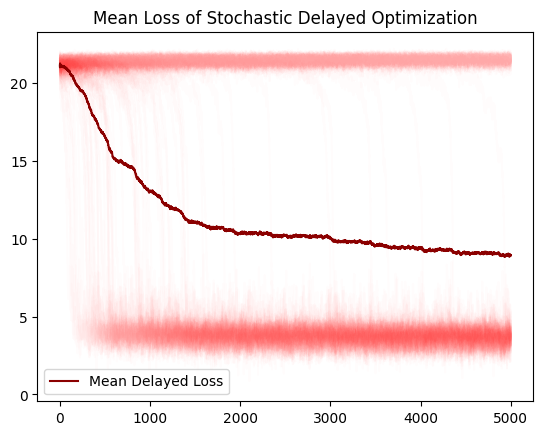

In [71]:
from matplotlib import pyplot as plt

# Example plot of the data
plt.plot(data.loss_vals, alpha=.01, c="r")
plt.plot(np.mean(data.loss_vals, axis=-1), c="darkred", label="Mean Delayed Loss")
plt.title("Mean Loss of Stochastic Delayed Optimization")
plt.legend()
plt.show()